In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import talib
from FinMind.data import DataLoader

api = DataLoader()
# api.login_by_token(api_token='token')
# api.login(user_id='user_id',password='password')
stock_info = api.taiwan_stock_info()

# 基本面指標和技術面指標的索引
fundamental_indices = ['營業收入淨額', '營業利益', '稅前淨利', '綜合損益歸屬母公司', '每股盈餘', 
                       '營業活動之淨現金流入_流出', '資產總額', '負債總額', '股東權益總額']
technical_indices = ['成交股數', '成交筆數', '成交金額', '收盤價', '開盤價', '最低價', '最高價', 
                     '最後揭示買價', '最後揭示賣價']


# 讀取數據
merged_data = pd.read_csv('merged_data.csv', index_col=[0, 1])

In [2]:
# 提取特定股票代號的資料
stock_id = '2330' 
stock_data = merged_data[merged_data.columns[merged_data.columns.str.contains(stock_id)]]

fundamental_data = stock_data.loc[fundamental_indices]
technical_data = stock_data.loc[technical_indices]

fundamental_data = fundamental_data.reset_index().pivot_table(index='date', columns='indicator', values=stock_id)
technical_data = technical_data.reset_index().pivot_table(index='date', columns='indicator', values=stock_id)

# 把日期轉成 datetime 類型
fundamental_data.index = pd.to_datetime(fundamental_data.index)
technical_data.index = pd.to_datetime(technical_data.index)

# 對 DataFrame 按照日期排序
fundamental_data = fundamental_data.sort_index()
technical_data = technical_data.sort_index()
technical_data.dropna(inplace=True)

# 特徵選擇
features = technical_data[['成交股數', '成交筆數', '成交金額', '開盤價', '最低價', '最高價', '最後揭示買價', '最後揭示賣價']]
target = technical_data['收盤價']  

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

tscv = TimeSeriesSplit(n_splits=5)

In [3]:
def run1(model, draw, name):
    cross_val_mse = []
    val_mse_per_fold = []
    fig, axs = plt.subplots(nrows=tscv.get_n_splits(X_train), ncols=1, figsize=(15, 8))
    
    # 在訓練集上進行交叉驗證
    for fold_idx, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)
        val_mse = mean_squared_error(y_val_fold, y_val_pred)
        cross_val_mse.append(val_mse)
        val_mse_per_fold.append(val_mse)
        
        # 畫出每個 fold 的預測值和實際值
        if draw == 1:
            axs[fold_idx].plot(y_val_fold.index, y_val_fold, label='Actual')
            axs[fold_idx].plot(y_val_fold.index, y_val_pred, label='Predicted')
            axs[fold_idx].set_title(f'{stock_id} {name} Fold {fold_idx+1} - Validation MSE: {val_mse}')
            axs[fold_idx].set_xlabel('Date')
            axs[fold_idx].set_ylabel('Closing Price')
            axs[fold_idx].legend()
            
            # 訓練模型
            model.fit(X_train_fold, y_train_fold)
            train_pred = model.predict(X_train_fold)

    plt.tight_layout()
    plt.show()

    print(name, " Cross Validation MSE:", cross_val_mse)
    print(name, "Cross Validation Mean MSE:", sum(cross_val_mse) / len(cross_val_mse))

    # 訓練模型
    model.fit(X_train, y_train)
    
    # 在測試集上進行預測
    y_test_pred = model.predict(X_test)

    # 計算測試集上的均方誤差
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(name, "Test MSE:", test_mse)

    # 畫出測試集的預測值和實際值
    plt.figure()
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, y_test_pred, label='Predicted')
    plt.title(f'{stock_id} {name} Test MSE: {test_mse}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.xticks(rotation=45)  # 將x軸文字旋轉45度
    plt.legend()
    plt.show()

In [4]:
def run(model, draw, name):
    cross_val_mse = []
    val_mse_per_fold = []
    fig, axs = plt.subplots(nrows=tscv.get_n_splits(X_train), ncols=2, figsize=(15, 8))
    
    # 在訓練集上進行交叉驗證
    for fold_idx, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)
        val_mse = mean_squared_error(y_val_fold, y_val_pred)
        cross_val_mse.append(val_mse)
        val_mse_per_fold.append(val_mse)
        
        # 畫出每個 fold 的預測值和實際值
        if draw == 1:
            axs[fold_idx, 1].plot(y_val_fold.index, y_val_fold, label='Actual')
            axs[fold_idx, 1].plot(y_val_fold.index, y_val_pred, label='Predicted')
            axs[fold_idx, 1].set_title(f'{stock_id} {name} Fold {fold_idx+1} - Validation MSE: {val_mse}')
            axs[fold_idx, 1].set_xlabel('Date')
            axs[fold_idx, 1].set_ylabel('Closing Price')
            axs[fold_idx, 1].legend()
            
            # 訓練模型
            model.fit(X_train_fold, y_train_fold)
            train_pred = model.predict(X_train_fold)
            
            # 畫出訓練集上的預測值和實際值
            axs[fold_idx, 0].plot(y_train_fold.index, y_train_fold, label='Actual')
            axs[fold_idx, 0].plot(y_train_fold.index, train_pred, label='Predicted')
            axs[fold_idx, 0].set_title(f'{stock_id} {name} Fold {fold_idx+1} - Train MSE')
            axs[fold_idx, 0].set_xlabel('Date')
            axs[fold_idx, 0].set_ylabel('Closing Price')
            axs[fold_idx, 0].legend()

    plt.tight_layout()
    plt.show()

    print(name, " Cross Validation MSE:", cross_val_mse)
    print(name, "Cross Validation Mean MSE:", sum(cross_val_mse) / len(cross_val_mse))

    # 訓練模型
    model.fit(X_train, y_train)
    
    # # 畫出訓練時的預測值和實際值
    # if draw == 1:
    #     train_pred = model.predict(X_train)
    #     plt.figure()
    #     plt.plot(y_train.index, y_train, label='Actual')
    #     plt.plot(y_train.index, train_pred, label='Predicted')
    #     plt.title(f'{stock_id} {name} Train MSE')
    #     plt.xlabel('Date')
    #     plt.ylabel('Closing Price')
    #     plt.xticks(rotation=45)  # 將x軸文字旋轉45度
    #     plt.legend()
    #     plt.show()

    # 在測試集上進行預測
    y_test_pred = model.predict(X_test)

    # 計算測試集上的均方誤差
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(name, "Test MSE:", test_mse)

    # 畫出測試集的預測值和實際值
    plt.figure()
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, y_test_pred, label='Predicted')
    plt.title(f'{stock_id} {name} Test MSE: {test_mse}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.xticks(rotation=45)  # 將x軸文字旋轉45度
    plt.legend()
    plt.show()

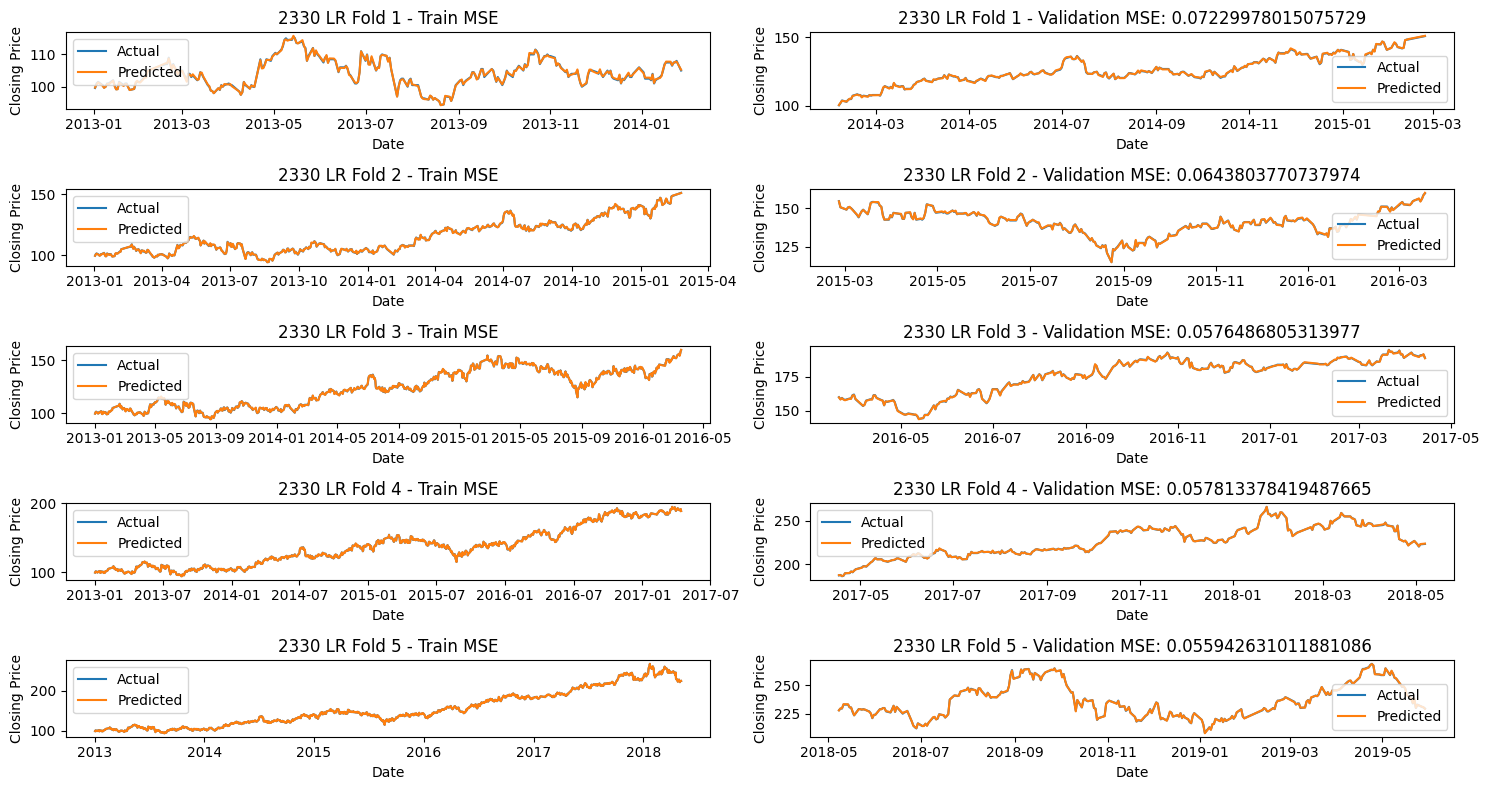

LR  Cross Validation MSE: [0.07229978015075729, 0.0643803770737974, 0.0576486805313977, 0.057813378419487665, 0.055942631011881086]
LR Cross Validation Mean MSE: 0.06161696943746423
LR Test MSE: 0.07688840748332346


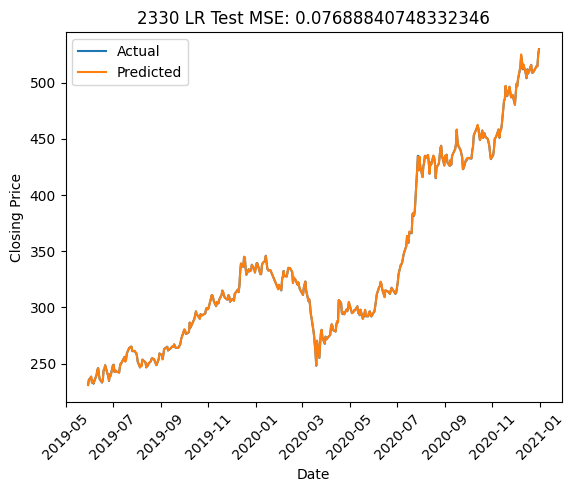

In [5]:
lr = LinearRegression()
run(lr, 1, "LR")



RF

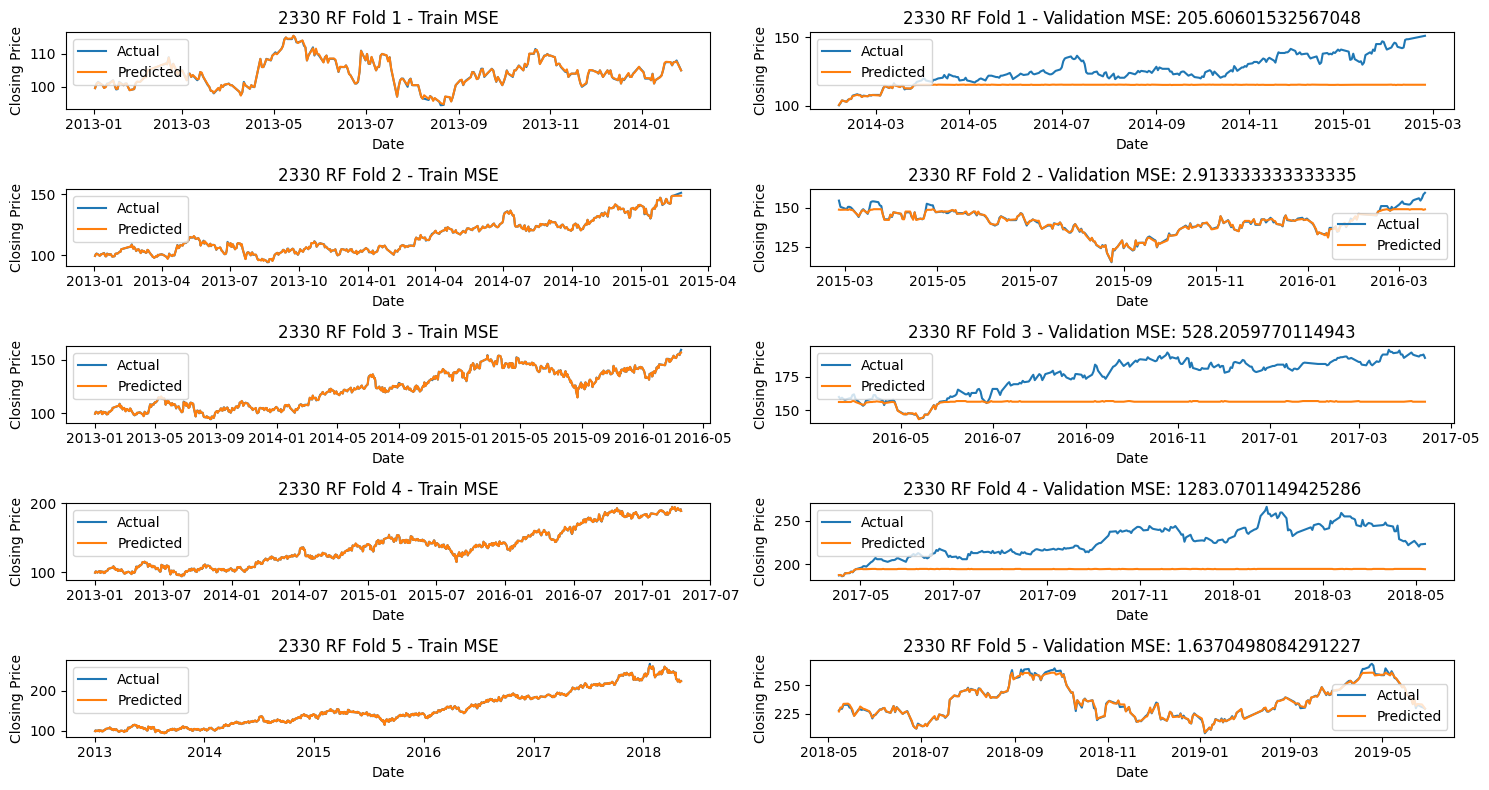

RF  Cross Validation MSE: [205.60601532567048, 2.913333333333335, 528.2059770114943, 1283.0701149425286, 1.6370498084291227]
RF Cross Validation Mean MSE: 404.2864980842911
RF Test MSE: 11699.800892857142


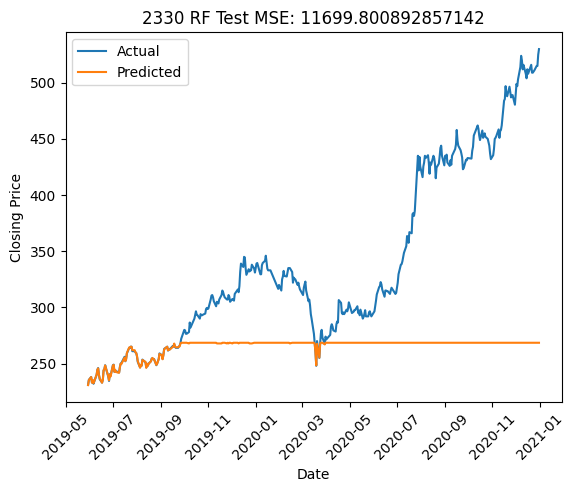

In [6]:
rf = RandomForestRegressor(n_estimators=5, random_state=42)
run(rf, 1, "RF")

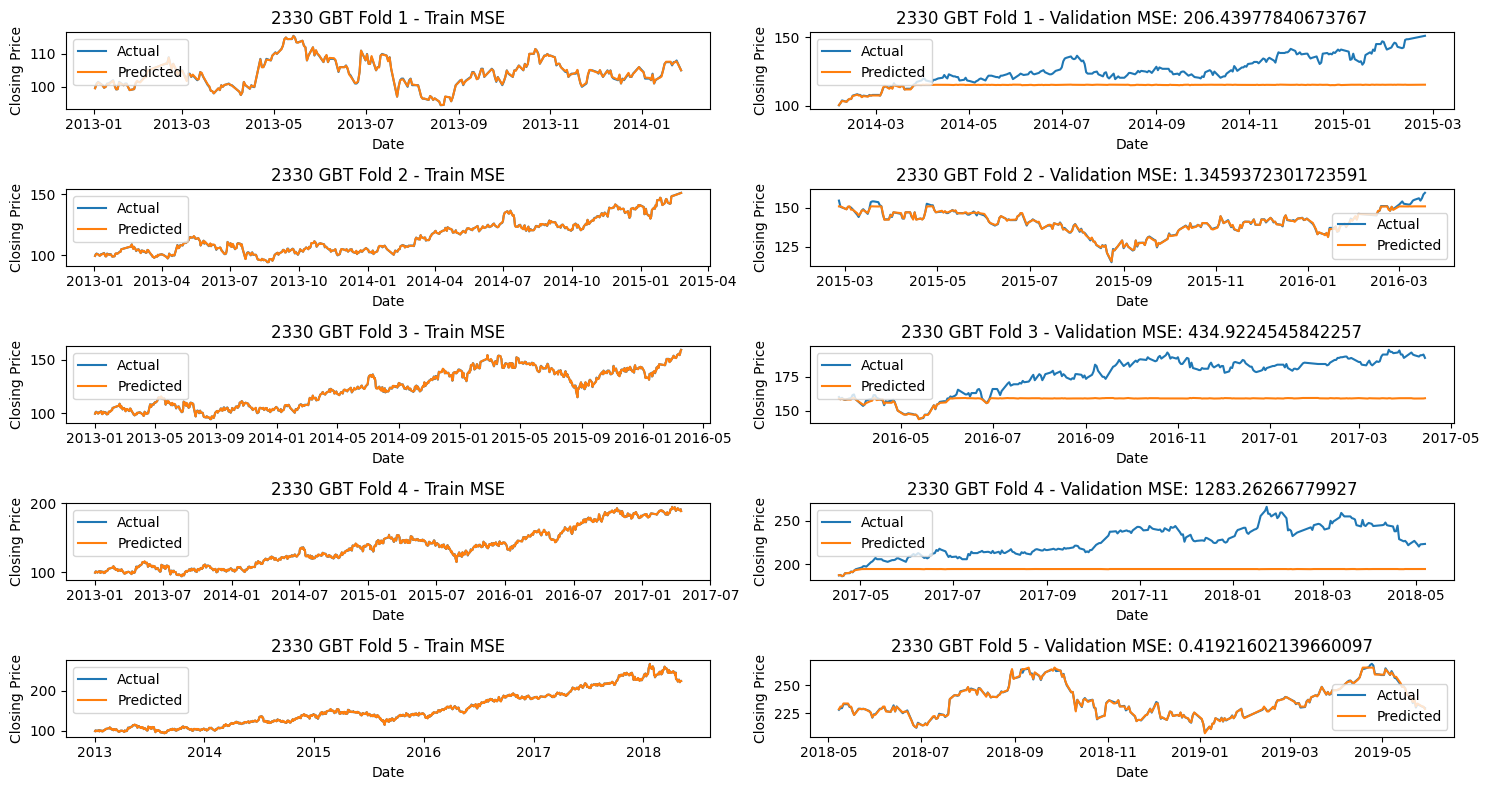

GBT  Cross Validation MSE: [206.43977840673767, 1.3459372301723591, 434.9224545842257, 1283.26266779927, 0.41921602139660097]
GBT Cross Validation Mean MSE: 385.2780108083605
GBT Test MSE: 11670.919819780926


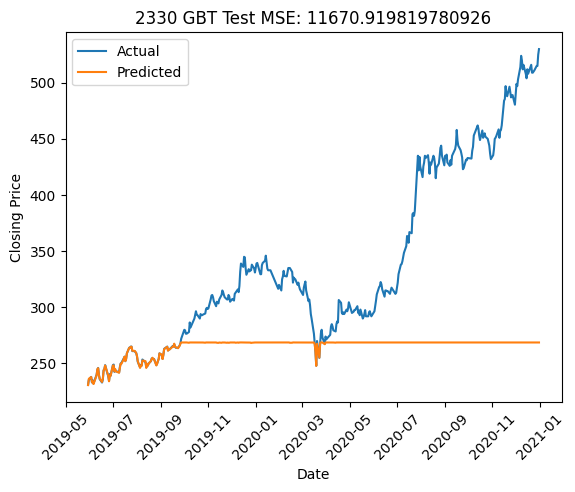

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

# 创建梯度提升树模型
gbt = GradientBoostingRegressor(n_estimators=100, random_state=42)

# 运行模型
run(gbt, 1, "GBT")
